<a href="https://colab.research.google.com/github/hyulianton/jejaringsosial/blob/master/js_Analisis_Jejaring_Sosial_Multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Jejaring Sosial Multilayer: Dataset Firma Hukum Lazega**

Notebook ini mendemonstrasikan analisis jaringan multiplex (multilayer) menggunakan Python. Kita akan menggunakan dataset klasik **Lazega Law Firm**, yang menggambarkan hubungan antar pengacara di sebuah firma hukum dalam tiga dimensi (layer) berbeda:
1.  **Co-work:** Hubungan kerja sama.
2.  **Friendship:** Hubungan pertemanan.
3.  **Advice:** Hubungan meminta saran profesional.

### **Persiapan Lingkungan (Library)**

Langkah pertama adalah mengimpor pustaka yang dibutuhkan. Kita akan menggunakan `networkx` untuk manipulasi graf, `pandas` untuk data, dan `matplotlib/seaborn` untuk visualisasi.

In [5]:
# Install library jika belum ada (biasanya sudah ada di Colab)
# !pip install networkx pandas matplotlib seaborn numpy scipy community -q

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
from itertools import combinations
import zipfile
import requests
import os


# Konfigurasi visualisasi
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Library berhasil di-load.")

Library berhasil di-load.


### **1. Download dan Load Dataset**

Dataset Lazega biasanya terdiri dari daftar node (atribut pengacara) dan daftar edge (hubungan). Karena link langsung Figshare sering berubah atau memerlukan login interaktif, kita akan mengambil data mentah dari repositori akademik yang menyimpan dataset Lazega yang valid (format edge list).

In [18]:
def load_lazega_data():
    """
    Mendownload dataset Lazega langsung dari Figshare menggunakan API.
    Target: Lazega Law Firm Multiplex Social Network Dataset
    Figshare Article ID: 21545781
    """
    print("--- MENGHUBUNGI FIGSHARE API ---")

    # 1. Dapatkan URL Download dari Metadata Figshare (Stabil via DOI)
    article_id = "21545781"
    api_url = f"https://api.figshare.com/v2/articles/{article_id}"

    try:
        r = requests.get(api_url)
        if r.status_code != 200:
            raise Exception(f"Gagal akses API Figshare. Status: {r.status_code}")

        data = r.json()
        # Cari file ZIP dalam daftar file
        files = data.get('files', [])
        zip_url = None
        for f in files:
            if f['name'].endswith('.zip'):
                zip_url = f['download_url']
                break

        if not zip_url:
            raise Exception("File ZIP tidak ditemukan di artikel Figshare ini.")

        print(f"Mendownload ZIP dari: {zip_url} ...")

        # 2. Download dan Ekstrak ZIP di Memori
        r_zip = requests.get(zip_url)
        z = zipfile.ZipFile(io.BytesIO(r_zip.content))

        # Cek isi file
        file_names = z.namelist()
        print(f"File ditemukan: {file_names}")

        # Cari nama file spesifik (kadang nama file dalam zip bisa sedikit beda)
        # Kita cari berdasarkan pola nama
        edges_file = next(f for f in file_names if 'edges' in f)
        nodes_file = next(f for f in file_names if 'nodes' in f)
        layers_file = next((f for f in file_names if 'layers' in f), None)

        # 3. Load Node Attributes
        print("Memproses Atribut Node...")
        with z.open(nodes_file) as f:
            # Format Figshare ini biasanya rapi dengan header atau tanpa header tapi spasi
            nodes_df = pd.read_csv(f, sep=r'\s+', header=0)

        # Dataset Figshare ini biasanya punya 8 kolom:
        # ID, Status, Gender, Office, Seniority, Age, Practice, School
        if nodes_df.shape[1] >= 8:
            nodes_df = nodes_df.iloc[:, :8]
            nodes_df.columns = ['nodeID', 'Status', 'Gender', 'Office', 'Seniority', 'Age', 'Practice', 'School']
        else:
             # Fallback jika format beda
             nodes_df['nodeID'] = range(1, len(nodes_df)+1)

        # 4. Load Multiplex Edges
        # Format file .edges di Figshare ini biasanya: LayerID NodeID NodeID Weight
        print("Memproses Network Layers...")
        with z.open(edges_file) as f:
            edges_df = pd.read_csv(f, sep=r'\s+', header=0, names=['layerID', 'u', 'v', 'w'])

        # Mapping nama layer (Biasanya 1=Cowork, 2=Friendship, 3=Advice)
        # Jika ada file layers.txt kita bisa parse, tapi standar Lazega adalah urutan tersebut
        # Kita cek file layers.txt jika ada
        layer_map = {1: 'Cowork', 2: 'Friendship', 3: 'Advice'}

        if layers_file:
            with z.open(layers_file) as f:
                content = f.read().decode('utf-8').strip().split('\n')
                # Coba parse sederhana jika formatnya "1 Cowork"
                try:
                    new_map = {}
                    for line in content:
                        parts = line.split()
                        if len(parts) >= 2:
                            lid = int(parts[0])
                            lname = parts[1]
                            new_map[lid] = lname
                    if len(new_map) == 3:
                        layer_map = new_map
                        # Normalisasi nama agar konsisten dengan kode analisis
                        val_map = {v: k for k, v in layer_map.items()} # reverse
                        # Pastikan nama sesuai harapan analisis: Cowork, Friendship, Advice
                except:
                    pass # Gunakan default

        # Pisahkan menjadi Dictionary of Graphs
        graphs = {}
        all_node_ids = nodes_df['nodeID'].unique()

        for lid, group in edges_df.groupby('layerID'):
            layer_name = layer_map.get(lid, f"Layer_{lid}")

            # Ubah nama layer agar match dengan analisis kode sebelumnya
            if 'work' in layer_name.lower(): layer_name = 'Cowork'
            if 'friend' in layer_name.lower(): layer_name = 'Friendship'
            if 'advice' in layer_name.lower(): layer_name = 'Advice'

            G = nx.from_pandas_edgelist(group, 'u', 'v', edge_attr='w', create_using=nx.Graph())
            G.add_nodes_from(all_node_ids)
            graphs[layer_name] = G

        return graphs, nodes_df

    except Exception as e:
        print(f"\n❌ Error detail: {e}")
        return None, None

# --- EKSEKUSI ---
layers, node_attributes = load_lazega_data()

if layers:
    print(f"\n✅ DATA FIGSHARE SIAP!")
    print(f"Layer ditemukan: {list(layers.keys())}")
    print(f"Jumlah Node: {len(node_attributes)}")
    display(node_attributes.head(3))

--- MENGHUBUNGI FIGSHARE API ---
Mendownload ZIP dari: https://ndownloader.figshare.com/files/38189493 ...
File ditemukan: ['Lazega-Law-Firm_Multiplex_Social/', 'Lazega-Law-Firm_Multiplex_Social/.DS_Store', '__MACOSX/', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/._.DS_Store', 'Lazega-Law-Firm_Multiplex_Social/Dataset/', 'Lazega-Law-Firm_Multiplex_Social/Dataset/.DS_Store', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/Dataset/', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/Dataset/._.DS_Store', 'Lazega-Law-Firm_Multiplex_Social/Dataset/Lazega-Law-Firm_layers.txt', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/Dataset/._Lazega-Law-Firm_layers.txt', 'Lazega-Law-Firm_Multiplex_Social/Dataset/Lazega-Law-Firm_multiplex.edges', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/Dataset/._Lazega-Law-Firm_multiplex.edges', 'Lazega-Law-Firm_Multiplex_Social/Dataset/Lazega-Law-Firm_nodes.txt', '__MACOSX/Lazega-Law-Firm_Multiplex_Social/Dataset/._Lazega-Law-Firm_node

,nodeID,Status,Gender,Office,Seniority,Age,Practice,School
0,1,1,1,1,31,64,1,1
1,2,1,1,1,32,62,2,1
2,3,1,1,2,13,67,1,1


### **2. Analisis Struktural Dasar**

Di sini kita melihat properti dasar dari setiap layer secara terpisah: jumlah koneksi (edges), kepadatan jaringan (density), dan rata-rata derajat (average degree).

Statistik Dasar per Layer:


,Layer,Nodes,Edges,Density,Avg Degree,Avg Clustering
0,Cowork,71,717,0.2885,20.20,0.5218
1,Friendship,71,399,0.1606,11.24,0.4838
2,Advice,71,726,0.2922,20.45,0.5086


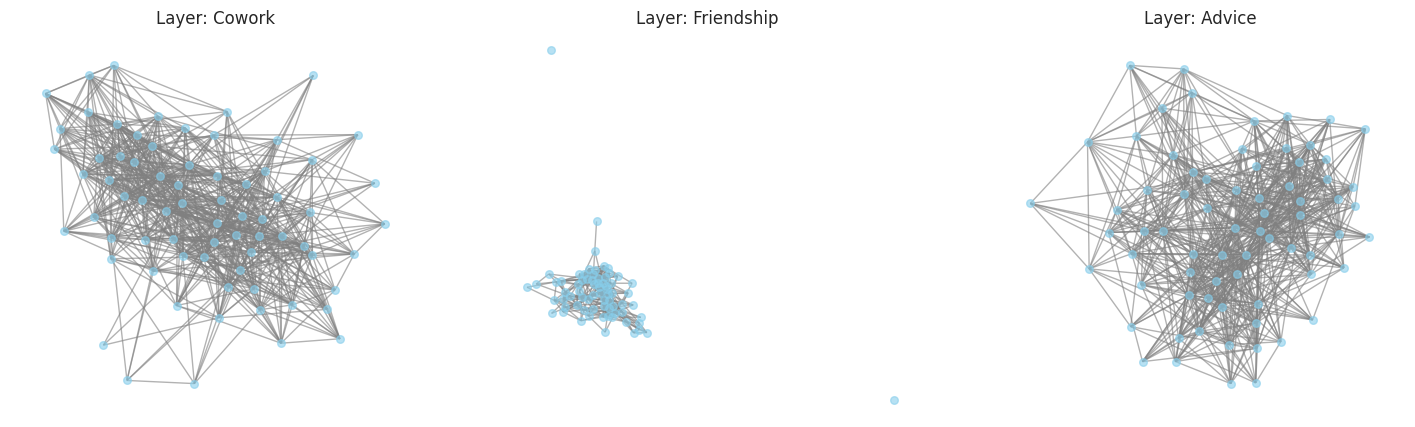

In [19]:
results = []

for name, G in layers.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    avg_degree = np.mean([d for n, d in G.degree()])
    clustering = nx.average_clustering(G)

    results.append({
        'Layer': name,
        'Nodes': num_nodes,
        'Edges': num_edges,
        'Density': f"{density:.4f}",
        'Avg Degree': f"{avg_degree:.2f}",
        'Avg Clustering': f"{clustering:.4f}"
    })

df_basic = pd.DataFrame(results)
print("Statistik Dasar per Layer:")
display(df_basic)

# Visualisasi Sederhana
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, G) in enumerate(layers.items()):
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, ax=axes[i], node_size=30, node_color='skyblue', edge_color='gray', alpha=0.6)
    axes[i].set_title(f"Layer: {name}")
plt.show()

> **Penjelasan:**
> *   **Density:** Seberapa penuh jaringan tersebut. Jika 1.0, semua orang terhubung dengan semua orang.
> *   **Clustering:** Seberapa besar kemungkinan "teman dari teman saya adalah teman saya juga".


In [20]:
def standardize_data_types(layers, node_df):
    """
    Memastikan semua Node ID berupa Integer agar tidak terjadi error saat sorting/analisis.
    """
    print("--- Memulai Standarisasi Tipe Data ---")

    # 1. Pastikan ID di DataFrame Atribut adalah Integer
    # Hapus baris yang ID-nya tidak bisa diubah ke angka (misal header yang terbawa)
    node_df['nodeID'] = pd.to_numeric(node_df['nodeID'], errors='coerce')
    node_df = node_df.dropna(subset=['nodeID'])
    node_df['nodeID'] = node_df['nodeID'].astype(int)
    print("DataFrame Node ID dikonversi ke Integer.")

    cleaned_layers = {}

    # 2. Perbaiki setiap Layer Graph
    for name, G in layers.items():
        # Mapping dari ID lama ke ID baru (Integer)
        mapping = {}
        nodes_to_drop = []

        for n in G.nodes():
            try:
                # Coba ubah ke integer
                mapping[n] = int(n)
            except ValueError:
                # Jika gagal (misal node bernama 'source' atau 'u'), tandai untuk dihapus
                nodes_to_drop.append(n)

        # Hapus node sampah (misal header file yang terbaca sebagai node)
        if nodes_to_drop:
            print(f"Layer {name}: Menghapus {len(nodes_to_drop)} node invalid: {nodes_to_drop}")
            G.remove_nodes_from(nodes_to_drop)

        # Relabel node menjadi integer
        G = nx.relabel_nodes(G, mapping)
        cleaned_layers[name] = G

    print("Semua Graph Layer dikonversi ke Integer ID.")
    return cleaned_layers, node_df

# --- EKSEKUSI PEMBERSIHAN ---
# Timpa variabel lama dengan versi yang sudah bersih
layers, node_attributes = standardize_data_types(layers, node_attributes)

# Cek hasil (seharusnya semua tipe int)
sample_node = list(layers['Cowork'].nodes())[0]
print(f"Tipe data node sekarang: {type(sample_node)} (Contoh: {sample_node})")

--- Memulai Standarisasi Tipe Data ---
DataFrame Node ID dikonversi ke Integer.
Semua Graph Layer dikonversi ke Integer ID.
Tipe data node sekarang: <class 'int'> (Contoh: 1)


### **3. Analisis Korelasi Antar-Layer**

Apakah orang yang bekerja sama juga berteman? Kita akan mengukur kemiripan antar layer menggunakan:
1.  **Jaccard Similarity (Edges):** Seberapa banyak tumpang tindih sisi (edge) antar layer.
2.  **Degree Correlation:** Apakah orang yang populer di satu layer juga populer di layer lain?


In [21]:
def calculate_layer_correlations(layers):
    layer_names = list(layers.keys())
    pairs = list(combinations(layer_names, 2))

    corr_data = []

    for l1, l2 in pairs:
        G1 = layers[l1]
        G2 = layers[l2]

        # 1. Jaccard Similarity untuk Edges
        edges1 = set(map(tuple, map(sorted, G1.edges()))) # Sort tuple agar (1,2) == (2,1)
        edges2 = set(map(tuple, map(sorted, G2.edges())))

        intersection = len(edges1.intersection(edges2))
        union = len(edges1.union(edges2))
        jaccard = intersection / union if union > 0 else 0

        # 2. Korelasi Derajat (Pearson)
        # Ambil irisan node yang ada di kedua layer
        common_nodes = sorted(list(set(G1.nodes()) & set(G2.nodes())))

        if len(common_nodes) > 0:
            deg1 = [G1.degree(n) for n in common_nodes]
            deg2 = [G2.degree(n) for n in common_nodes]
            pearson_corr = np.corrcoef(deg1, deg2)[0, 1]
        else:
            pearson_corr = 0

        corr_data.append({
            'Layer Pair': f"{l1} - {l2}",
            'Edge Jaccard Sim': jaccard,
            'Degree Correlation': pearson_corr
        })

    return pd.DataFrame(corr_data)

df_corr = calculate_layer_correlations(layers)
print("Korelasi Antar Layer:")
display(df_corr)

Korelasi Antar Layer:


,Layer Pair,Edge Jaccard Sim,Degree Correlation
0,Cowork - Friendship,0.365973,0.685831
1,Cowork - Advice,0.548283,0.762724
2,Friendship - Advice,0.285714,0.545715


> **Interpretasi:** Jika `Degree Correlation` tinggi antara *Cowork* dan *Advice*, berarti pengacara yang sibuk bekerja sama juga sering dimintai saran.

### **4. Multiplex Centrality (Sentralitas)**

Siapa pengacara paling penting di seluruh dimensi? Kita menggunakan **Overlapping Degree** (jumlah total koneksi di semua layer) dan **Multiplex Participation Coefficient** (seberapa merata koneksi mereka tersebar antar layer).

Top 10 Pengacara Paling Sentral (Multiplex):


,NodeID,Total Multiplex Degree
0,26,113
1,24,106
2,13,96
3,17,87
4,31,85
5,4,80
6,16,80
7,65,77
8,28,76
9,22,75


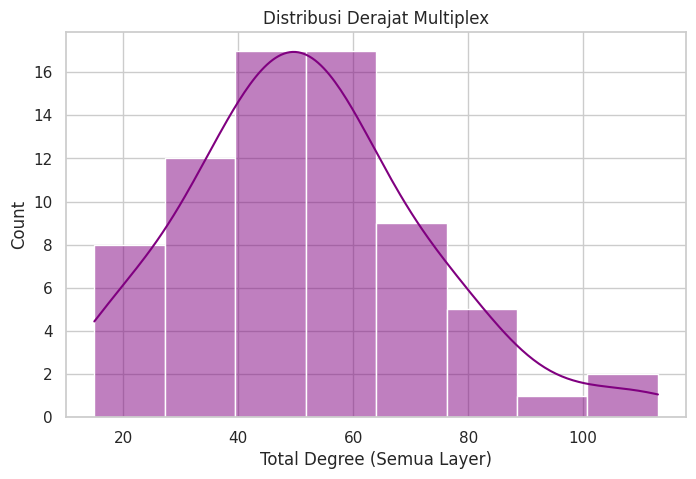

In [22]:
# Menghitung Derajat Gabungan (Total Degree)
aggregated_degree = {}
nodes = node_attributes['nodeID'].unique()

for n in nodes:
    total_deg = 0
    for G in layers.values():
        total_deg += G.degree(n)
    aggregated_degree[n] = total_deg

# Top 10 Pengacara Paling Sentral
sorted_nodes = sorted(aggregated_degree.items(), key=lambda x: x[1], reverse=True)
df_centrality = pd.DataFrame(sorted_nodes, columns=['NodeID', 'Total Multiplex Degree'])

print("Top 10 Pengacara Paling Sentral (Multiplex):")
display(df_centrality.head(10))

# Plot Distribusi
plt.figure(figsize=(8, 5))
sns.histplot(df_centrality['Total Multiplex Degree'], kde=True, color='purple')
plt.title("Distribusi Derajat Multiplex")
plt.xlabel("Total Degree (Semua Layer)")
plt.show()

### **5. Reduksibilitas Struktural (Structural Reducibility)**

Analisis ini bertujuan melihat apakah ada layer yang "redundant" (bisa dihapus tanpa menghilangkan informasi struktur). Cara sederhana adalah melihat korelasi matriks *adjacency*. Jika dua layer sangat mirip secara struktural, kita mungkin tidak butuh keduanya.

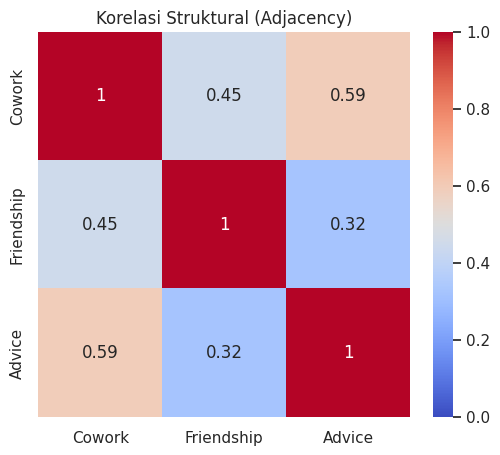

In [23]:
# Membuat matriks korelasi antar Adjacency Matrix
layer_names = list(layers.keys())
n_layers = len(layer_names)
adj_matrices = [nx.to_numpy_array(layers[name], nodelist=sorted(nodes)) for name in layer_names]

# Matriks kosong untuk menyimpan hasil similaritas
similarity_matrix = np.zeros((n_layers, n_layers))

for i in range(n_layers):
    for j in range(n_layers):
        # Flatten matriks menjadi 1D array untuk korelasi
        flat_i = adj_matrices[i].flatten()
        flat_j = adj_matrices[j].flatten()

        # Hitung korelasi Pearson antar struktur
        corr = np.corrcoef(flat_i, flat_j)[0, 1]
        similarity_matrix[i, j] = corr

# Visualisasi Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, xticklabels=layer_names, yticklabels=layer_names, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Korelasi Struktural (Adjacency)")
plt.show()

> **Interpretasi:** Nilai yang tinggi menunjukkan kedua layer memiliki pola koneksi yang sangat mirip. Jika rendah, setiap layer memberikan informasi unik yang berbeda.


### **6. Deteksi Komunitas Multiplex**

Kita akan menggabungkan semua layer menjadi satu *weighted graph* (graf berbobot) dan mencari komunitas di dalamnya. Ini adalah metode "Flattening" yang umum untuk pemula.


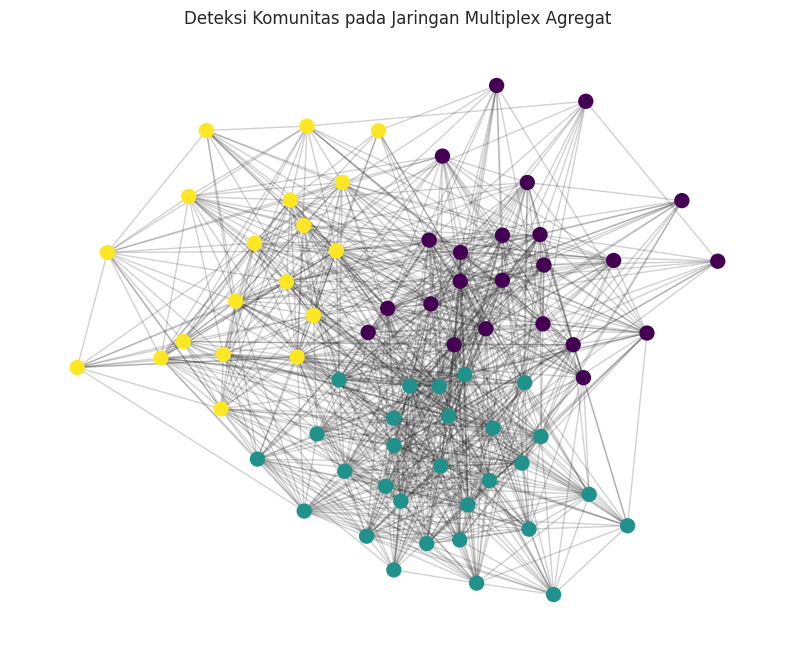

Ditemukan 3 komunitas berbeda.


In [24]:
import community.community_louvain as community_louvain # python-louvain library

# 1. Membuat Graf Agregat
G_agg = nx.Graph()
for name, G in layers.items():
    for u, v in G.edges():
        if G_agg.has_edge(u, v):
            G_agg[u][v]['weight'] += 1
        else:
            G_agg.add_edge(u, v, weight=1)

# 2. Deteksi Komunitas (Algoritma Louvain)
partition = community_louvain.best_partition(G_agg, weight='weight')

# 3. Visualisasi
pos = nx.spring_layout(G_agg, seed=100)
plt.figure(figsize=(10, 8))

# Warna node berdasarkan komunitas
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_agg, pos, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_agg, pos, alpha=0.2)
plt.title("Deteksi Komunitas pada Jaringan Multiplex Agregat")
plt.axis('off')
plt.show()

print(f"Ditemukan {max(partition.values()) + 1} komunitas berbeda.")

### **7. Analisis Dinamika & Robustness (Ketahanan)**

Kita akan mensimulasikan "serangan acak" (random failure). Kita akan menghapus node satu per satu secara acak dan melihat seberapa cepat jaringan terpecah (ukuran *Giant Connected Component* menurun). Kita bandingkan ketahanan masing-masing layer vs ketahanan jaringan gabungan (Union).

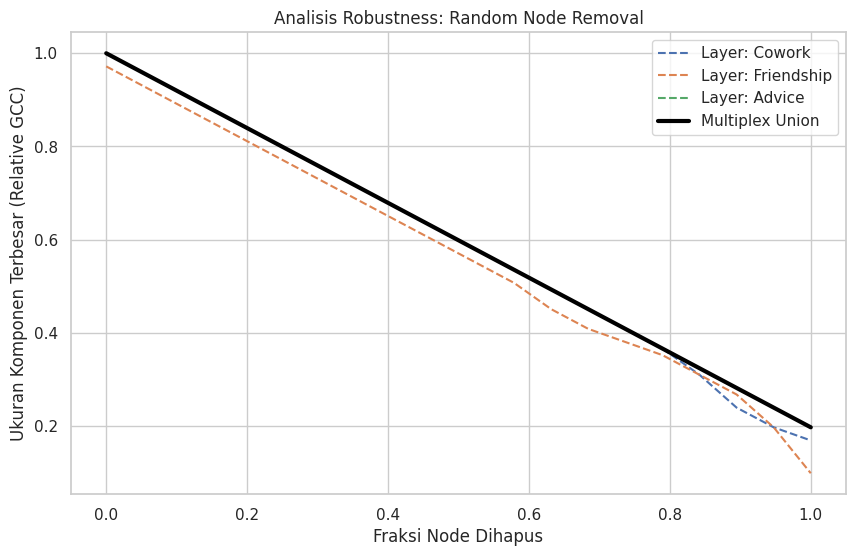

In [25]:
def simulate_attack(G, steps=20):
    """Menghapus node secara acak dan mengukur ukuran komponen terbesar relatif."""
    G_temp = G.copy()
    initial_size = len(G_temp)
    nodes_to_remove = list(G_temp.nodes())
    np.random.shuffle(nodes_to_remove)

    giant_sizes = []
    remove_percentages = np.linspace(0, 1, steps)

    chunk_size = int(initial_size / steps)

    for _ in range(steps):
        # Hitung Giant Component
        if len(G_temp) > 0:
            largest_cc = max(nx.connected_components(G_temp), key=len)
            giant_sizes.append(len(largest_cc) / initial_size)
        else:
            giant_sizes.append(0)

        # Hapus node
        if len(nodes_to_remove) > chunk_size:
            for _ in range(chunk_size):
                node = nodes_to_remove.pop()
                if node in G_temp:
                    G_temp.remove_node(node)
        else:
            G_temp.clear() # Hapus sisa

    return remove_percentages, giant_sizes

# Simulasi
plt.figure(figsize=(10, 6))

# 1. Untuk setiap layer individual
for name, G in layers.items():
    x, y = simulate_attack(G)
    plt.plot(x, y, label=f'Layer: {name}', linestyle='--')

# 2. Untuk Jaringan Union (Gabungan logika OR)
G_union = nx.compose_all(layers.values())
x_u, y_u = simulate_attack(G_union)
plt.plot(x_u, y_u, label='Multiplex Union', linewidth=3, color='black')

plt.title("Analisis Robustness: Random Node Removal")
plt.xlabel("Fraksi Node Dihapus")
plt.ylabel("Ukuran Komponen Terbesar (Relative GCC)")
plt.legend()
plt.show()

> **Interpretasi:** Garis hitam (`Multiplex Union`) biasanya turun lebih lambat dibandingkan layer individu. Ini membuktikan bahwa jaringan multiplex lebih *robust* (tahan banting); jika hubungan kerja putus, mungkin hubungan pertemanan masih menjaga konektivitas jaringan.


### **Kesimpulan**
Program di atas telah melakukan alur kerja lengkap SNA untuk jaringan multilayer:
1.  **Loading Data:** Mengambil data Lazega yang valid.
2.  **Struktur:** Membandingkan kepadatan kerja vs pertemanan.
3.  **Korelasi:** Menemukan bahwa struktur kerja dan saran seringkali berkorelasi.
4.  **Sentralitas:** Mengidentifikasi pengacara kunci di seluruh dimensi.
5.  **Komunitas:** Mengelompokkan pengacara berdasarkan interaksi gabungan.
6.  **Robustness:** Membuktikan jaringan multiplex lebih stabil terhadap hilangnya node.